In [1]:
from pathlib import Path
import os
code_dir = Path().cwd().parent
os.chdir(code_dir)

In [2]:
import functions as funcs
import matplotlib.pyplot as plt
import cv2
import numpy as np
import shutil
import random
from ultralytics import YOLO
import pickle

In [3]:
image_dir = Path() /'D:'/'singh'/'Documents'/'zoo'

In [ ]:
if not (image_dir/'Good_Bad').is_dir():
    good_bad_dir = image_dir/'Good_Bad'
    good_bad_dir.mkdir(parents=True, exist_ok=True)
else:
    good_bad_dir = image_dir/'Good_Bad'

In [ ]:
# Hot many images are there?
bad_counter = 0
for file in (good_bad_dir/'Low_Quality').iterdir():
    if (file.is_file()) & (file.suffix in ['.jpeg', '.jpg']):
        img = funcs.get_image_from_path(file_path=file)
        if img.shape == (1000,1000,3):
            bad_counter+=1 
print(f"{bad_counter=}")

In [ ]:
good_temp_folder = image_dir/'temp_image_folder_good'
good_temp_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
ai_training_dir = Path().cwd().parent / r"AI Training Sets-20231024T092556Z-001"/r"AI Training Sets"
ai_training_dir

In [ ]:
good_image_folders = ["Set4-1_WBC_Images", 
                      "Set5-1_WBC_Images", 
                      r"Goldilocks-Test_Images/Good", 
                      r"Goldilocks-Test_Images/Dense", 
                      r"Goldilocks-Test_Images/Sparse", 
                      "No_WBCs_Images"]

In [ ]:
file_counter = 0
for folder in good_image_folders:
    for file in (ai_training_dir/folder).iterdir():
         if (file.is_file()) & (file.suffix in ['.jpeg', '.jpg']):
            img = funcs.get_image_from_path(file_path=file)
            if img.shape == (1000,1000,3):
                assert good_temp_folder.exists(), "Folder not found"
                shutil.copy(src=file, dst=good_temp_folder)
                file_counter += 1
                print(f"file_counter:{file_counter:03d}", end='\r')

In [ ]:
def rotate_image_thrice(image:np.ndarray) -> tuple[np.ndarray]:
    """ Takes an image and rotates it three times clockwise 
        and returns rotated images """
    rot_90 = cv2.rotate(src=image,rotateCode=cv2.ROTATE_90_CLOCKWISE)
    rot_180 = cv2.rotate(src=rot_90,rotateCode=cv2.ROTATE_90_CLOCKWISE)
    rot_270 = cv2.rotate(src=rot_180,rotateCode=cv2.ROTATE_90_CLOCKWISE)
    return rot_90, rot_180, rot_270

In [ ]:
good_temp_files = [file for file in good_temp_folder.iterdir() if (file.is_file())  & (file.suffix in ['.jpeg', '.jpg'])]
len(good_temp_files)

In [ ]:
(2400-len(good_temp_files)) - 3*124

In [ ]:
# Saving additional augmented 124 files to balance the dataset 
for file in good_temp_files[:124]:
    file_name = file.parts[-1].split(".")[0]
    img = funcs.get_image_from_path(file_path=file)
    rot90, rot180, rot270 = rotate_image_thrice(image=img)
    for img, img_name in zip([rot90, rot180, rot270],
                             [f"{file_name}_90.jpg", f"{file_name}_180.jpg", f"{file_name}_270.jpg"]):
        funcs.save_image_to_path(image=img, file_path=good_temp_folder/img_name)        

In [ ]:
good_temp_files = [file for file in good_temp_folder.iterdir() if (file.is_file())  & (file.suffix in ['.jpeg', '.jpg'])]
len(good_temp_files)

In [ ]:
random.shuffle(good_temp_files)

In [ ]:
split_index = int(0.80 * len(good_temp_files))
good_train_files = good_temp_files[:split_index]
good_val_files = good_temp_files[split_index:]

In [ ]:
train_dir = image_dir/"good_bad_dataset"/'train'
val_dir = image_dir/"good_bad_dataset"/'val'
for file in good_train_files:
    dest = train_dir/'good'
    if dest.is_dir():    
        shutil.copy(src=file, dst=dest)
        
for file in good_val_files:
    dest = val_dir/'good'
    if dest.is_dir():    
        shutil.copy(src=file, dst=dest)

In [ ]:
sum([1 for file in (train_dir/'good').iterdir() if file.is_file()]), sum([1 for file in (val_dir/'good').iterdir() if file.is_file()])

In [ ]:
bad_counter*4

In [ ]:
test_file = good_bad_dir/'Low_Quality'/"B087_3M2_T19004_RT_x40_z0_i42j30.jpg"

img = funcs.get_image_from_path(file_path=test_file)
rot_90, rot_180, rot_270 = rotate_image_thrice(image=img)

_, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,6))
ax[0].imshow(img)
ax[0].set_title('Original')
ax[1].imshow(rot_90)
ax[1].set_title('Rot90')
ax[2].imshow(rot_180)
ax[2].set_title('Rot180')
ax[3].imshow(rot_270)
ax[3].set_title('Rot270')
plt.show()

In [ ]:
def make_classification_folders(folder_path:Path=None, 
                                dir_name:str="good_bad_dataset", 
                                classes:list[str]=['good', 'bad']) -> None:
    """ Makes a directory structure for the Yolo image classification training 
    """
    if folder_path is None:
        folder_path = Path.cwd()
    
    if (folder_path/dir_name).is_dir():
        print("Folder exists - not creating new ones")
        return

    root_folder = folder_path/dir_name
    subfolders = ['train', 'val']
    for subfolder in subfolders:
        train_val_folders = root_folder/subfolder
        for cls in classes:
            class_folder = train_val_folders/cls
            
            train_val_folders.mkdir(parents=True, exist_ok=True)
            class_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
make_classification_folders(folder_path=image_dir)

In [ ]:
# split train-val -> 80-20
2400 * 0.80, 2400 * 0.20 

In [ ]:
temp_folder = image_dir/'temp_image_folder'
temp_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
if not any((temp_folder).iterdir()):
    for file in (good_bad_dir/'Low_Quality').iterdir():
        if (file.is_file()) & (file.suffix in ['.jpeg', '.jpg']):
            file_name = file.parts[-1].split(".")[0]
            img = funcs.get_image_from_path(file_path=file)
            rot90, rot180, rot270 = rotate_image_thrice(image=img)
            for img, img_name in zip([img, rot90, rot180, rot270], 
                                    [f"{file_name}.jpg", f"{file_name}_90.jpg", f"{file_name}_180.jpg", f"{file_name}_270.jpg"]):
                funcs.save_image_to_path(image=img, file_path=temp_folder/img_name)
else:
    print("Temp folder has files in it")

In [ ]:

temp_files = [file for file in temp_folder.iterdir() if (file.is_file()) & (file.suffix == '.jpg')]
random.shuffle(temp_files)

In [ ]:
split_index = int(0.80 * len(temp_files))
train_files = temp_files[:split_index]
val_files = temp_files[split_index:]

In [ ]:
train_dir = image_dir/"good_bad_dataset"/'train'
val_dir = image_dir/"good_bad_dataset"/'val'
for file in val_files:
    shutil.copy(src=file, dst=val_dir/'bad')

In [ ]:
print(sum([1 for file in (val_dir/'bad').iterdir() if (file.is_file()) & (file.suffix == '.jpg')]))
print(sum([1 for file in (train_dir/'bad').iterdir() if (file.is_file()) & (file.suffix == '.jpg')]))

In [ ]:
# Delete the temp folder
shutil.rmtree(temp_folder)

In [ ]:
good_bad_model = YOLO(model=code_dir/'Good_Bad'/"good_bad_weights_16Dec23.pt")

In [ ]:
aug_img_files = [file for file in (ai_training_dir/"Augmentated_Images").iterdir() if file.is_file()]
aug_img_files

In [ ]:
results = good_bad_model.predict(aug_img_files[0])

In [ ]:
aug_img_classify = [result[0].names[np.argmax(result[0].probs.data.numpy())] for result in [good_bad_model.predict(file) for file in aug_img_files]]
aug_img_classify

In [ ]:
low_qual_files = [] 
for file in list((good_bad_dir/"Low_Quality").iterdir())[:20]:
    if file.is_file():
        img = funcs.get_image_from_path(file_path=file)
        img = cv2.rotate(src=img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        low_qual_files.append(img)

In [ ]:
low_qual_classify = [result[0].names[np.argmax(result[0].probs.data.numpy())] for result in [good_bad_model.predict(file) for file in low_qual_files]]

In [ ]:
low_qual_score = sum([1 for pred in low_qual_classify if pred=="bad"])/len(low_qual_classify)
low_qual_score

## Apply model on patches

In [4]:
         
patch_file_names = [file for file in (image_dir/r"[B001]0J4_T19085_RT").iterdir() if (file.is_file()) & (file.suffix in['.jpeg', '.jpg'])]

In [5]:
if (code_dir/'Good_Bad'/'patch_class_results.pickle').exists():
    with open(file=code_dir/'Good_Bad'/'patch_class_results.pickle', mode='rb') as f:
        patch_classify_result = pickle.load(file=f)
    print("Loading existing patch_classify_result")
else:
    print("Calculating patch_classify_result")
    patch_classify_result = [result[0].names[np.argmax(result[0].probs.data.numpy())] for result in [good_bad_model.predict(file) for file in patch_file_names]]
    with open(file=code_dir/'Good_Bad'/'patch_class_results.pickle', mode='wb') as f:
        pickle.dump(obj=patch_classify_result, file=f)

Loading existing patch_classify_result


In [6]:
good_patch_indices = [i for i, result in enumerate(patch_classify_result) if result=='good']
bad_patch_indices = [i for i, result in enumerate(patch_classify_result) if result=='bad']

In [ ]:
len(good_patch_indices), len(patch_classify_result), len(bad_patch_indices)

In [ ]:
good_images = [funcs.get_image_from_path(file_path=patch_file_names[idx]) for idx in good_patch_indices[4:8]]
bad_images = [funcs.get_image_from_path(file_path=patch_file_names[idx]) for idx in bad_patch_indices[4:8]]

In [ ]:
_, ax = plt.subplots(nrows=2, ncols=len(good_images), figsize=(10,5))
for col, good_img in enumerate(good_images):
    ax[0,col].imshow(good_img)
    ax[0,col].set_title("Good patch")
    ax[0,col].axis('off')
for col, bad_img in enumerate(bad_images):
    ax[1,col].imshow(bad_img)
    ax[1,col].set_title("Bad patch")
    ax[1,col].axis('off')
plt.show()

In [ ]:
test_img_path = patch_file_names[good_patch_indices[31]]
test_img = funcs.get_image_from_path(file_path=test_img_path)
plt.imshow(test_img)
plt.show()

In [7]:
good_patch_file_names = [patch_file_names[ind] for ind in good_patch_indices]

In [ ]:
for file in good_patch_file_names:
    if file.is_file():
        shutil.copy(src=file, dst=image_dir/'Good_Patches')

In [ ]:
image_dir/'Good_Patches'

In [8]:
yolo_model = YOLO(model=Path().cwd().parent /'Yolo'/"best.pt")

In [39]:
test_patch_result = yolo_model.predict(source=good_patch_file_names[60])


image 1/1 D:singh\Documents\zoo\[B001]0J4_T19085_RT\[B001]0J4_T19085_RT_10_25.jpg: 1024x1024 1 Neutrophil, 1 Monocyte, 5094.9ms
Speed: 21.9ms preprocess, 5094.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


In [64]:
image_file_name = Path(test_patch_result[0].path).parts[-1]
image_file_name

'[B001]0J4_T19085_RT_10_25.jpg'

In [40]:
class_index = test_patch_result[0].boxes.cls.numpy().astype(np.uint)

In [53]:
class_labels = [test_patch_result[0].names[idx] for idx in class_index]
class_labels

['Monocyte', 'Neutrophil']

In [52]:
test_patch_result[0].cpu().boxes.xywh

tensor([[359.7085, 871.4561,  66.8315,  66.7441],
        [ 13.1993, 296.3510,  26.3498,  72.5641]])

In [69]:
from collections import defaultdict

In [72]:
res_dic = {}
sub_dict = {}

TypeError: unhashable type: 'collections.defaultdict'

In [73]:
res_dic = {image_file_name: {"class_labels":class_labels, 'boxes':test_patch_result[0].cpu().boxes.xywh.numpy()}}
res_dic

{'[B001]0J4_T19085_RT_10_25.jpg': {'class_labels': ['Monocyte', 'Neutrophil'],
  'boxes': array([[     359.71,      871.46,      66.832,      66.744],
         [     13.199,      296.35,       26.35,      72.564]], dtype=float32)}}

In [75]:
res_dic['[B001]0J4_T19085_RT_10_25.jpg']['boxes']

array([[     359.71,      871.46,      66.832,      66.744],
       [     13.199,      296.35,       26.35,      72.564]], dtype=float32)

In [ ]:
test_img_path1 = patch_file_names[good_patch_indices[0]]
test_img_path1

In [ ]:
test_result1 = yolo_model.predict(source=test_img_path1)
# If there are not detections
test_result1[0].boxes.data.numpy().size == 0

In [ ]:
test_results = yolo_model.predict(source=test_img_path)

In [ ]:
test_results[0].names, test_results[0].path.split("\\")[-1].split(".")[0]

In [ ]:
boxes = test_results[0].boxes.xywh.numpy().astype(np.int32)
boxes

In [101]:
def get_roi(image: np.ndarray, 
            xy: tuple[int, int] | np.ndarray, 
            offset: tuple[int, int] = (70, 70)) -> np.ndarray:
    """ Given an image and xy coordinates, returns the ROI from the image using the offset 
    """
    img_height, img_width, _ = image.shape
    x, y = xy

    # Ensure the ROI does not exceed image dimensions
    x = max(0, min(x, img_width - 1))
    y = max(0, min(y, img_height - 1))

    # Calculate ROI boundaries using the offset
    roi_x1 = max(0, x - offset[0])
    roi_y1 = max(0, y - offset[1])
    roi_x2 = min(img_width, x + offset[0])
    roi_y2 = min(img_height, y + offset[1])

    # Extract the ROI using NumPy array slicing
    roi = image[roi_y1:roi_y2, roi_x1:roi_x2, :]

    return roi

In [ ]:
roi = get_roi(image=test_results[0].orig_img[...,::-1], xy=boxes[1][:2])

In [ ]:
plt.imshow(roi)
plt.show()

In [ ]:
boxes = test_results[0].boxes.xywh.numpy().astype(np.int32)


In [ ]:
for i, box in enumerate(boxes):
    xy = box[:2]
    roi = get_roi(image=test_results[0].orig_img[..., ::-1], xy=xy)
    box_name = f"{i:02d}"
    file_name = test_results[0].path.split("\\")[-1].split(".")[0]
    print(f"{file_name}_B{box_name}")

In [ ]:
set([test_results[0].names[pred_class] for pred_class in test_results[0].boxes.cls.numpy().astype(np.uint)])

In [ ]:
rl = ['[B001]0J4_T19085_RT_0_38_00', '[B001]0J4_T19085_RT_0_38_01', '[B001]0J4_T19085_RT_0_38_02']
[r[:-3] for r in rl] 

In [ ]:
for cell_name in set([test_results[0].names[pred_class] for pred_class in test_results[0].boxes.cls.numpy().astype(np.uint)]):
    folder= Path().cwd()/"Good_Bad"/cell_name
    folder.mkdir(parents=True, exist_ok=True)

In [ ]:
from ultralytics.engine.results import Results

In [ ]:
def save_rois(result:Results, folder_path:Path) -> None:
    """Takes a YOLO result object, extracts the ROI boxes 
        and saves them in corresponding folders
    """
    assert isinstance(folder_path, Path), "folder_path needs to be a Path object"
    # No detections
    if result[0].boxes.data.numpy().size == 0:
        return 
    # For detections
    image_name = result[0].path.split("\\")[-1].split(".")[0]
    names_dict = result[0].names
    boxes = result[0].boxes.xywh.numpy().astype(np.int32)
    classification = [names_dict[cls] for cls in result[0].boxes.cls.numpy().astype(np.uint)]
    for i, (box, cls) in enumerate(zip(boxes, classification)):
        xy = box[:2]
        roi = get_roi(image=result[0].orig_img[..., ::-1], xy=xy)
        box_name = f"B{i:02d}"
        file_name = f"{image_name}_{box_name}.jpg"
        assert (folder_path/cls).exists(), "Folder not found"
        funcs.save_image_to_path(image = roi, file_path=folder_path/cls/file_name)

In [ ]:
save_rois(result=test_results, folder_path=Path().cwd()/"Good_Bad")

In [154]:
def find_roi_in_image(image: np.ndarray, roi: np.ndarray) -> tuple:
    # Find the location of a ROI in an image
    whole_gray = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(src=roi, code=cv2.COLOR_BGR2GRAY)

    # Perform template matching
    result = cv2.matchTemplate(whole_gray, template_gray, cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(result)

    # Get the dimensions of the template
    roi_h, roi_w = template_gray.shape

    # Calculate the center of the found ROI
    x = max_loc[0] + roi_w // 2
    y = max_loc[1] + roi_h // 2

    return x, y, roi_w, roi_h


In [ ]:
test_roi = funcs.get_image_from_path(file_path=r"Good_Bad\Neutrophil\[B001]0J4_T19085_RT_0_38_B02.jpg")

In [ ]:
find_roi_in_image(image=test_results[0].orig_img[...,::-1], roi=test_roi)

In [ ]:
test_im = test_results[0].orig_img[...,::-1].astype(np.int32)
test_im2 = cv2.circle(img=test_im, center=(251, 977), radius=5, color=(255,0,0), thickness=3)
plt.imshow(test_im2)
plt.show() 



In [ ]:
# patch_file_names

# get the patch file name from roi image
test_roi_img_path = Path().cwd() /"Good_Bad"/"Monocyte"/r"[B001]0J4_T19085_RT_0_38_B01.jpg"

In [ ]:
test_extract = test_roi_img_path.parts[-1].split('.')[0][:-4] + ".jpg"
test_extract

In [ ]:
patch_image_names = [patch_file_name.parts[-1] for patch_file_name in patch_file_names]

In [ ]:
test_extract in patch_image_names

In [148]:
def get_patch_name_from_roi_file(roi_file:Path) -> str:
    """ Returns the patch name from a ROI image path
    Example:
    [B001]0J4_T19085_RT_0_38_B01.jpg -> [B001]0J4_T19085_RT_0_38.jpg
    Assuming the box id (B01) is 3 characters long
    """
    assert isinstance(roi_file, Path), "roi_file needs to be Path object"
    return roi_file.parts[-1].split(".")[0][:-4]+".jpg"

In [ ]:
# Find ROI images in 
for file in (Path()/"Good_Bad"/"Monocyte").iterdir():
    if file.is_file():
        print(file.parts[-1], get_patch_name_from_roi_file(roi_file=file))

In [78]:
with open(file=Path().cwd()/"Good_Bad"/"good_patch_results.pickle", mode='rb') as f:
    good_patch_results = pickle.load(file=f)

In [87]:
# for key, val in good_patch_results.items():
#     print(key, val)

In [89]:
good_patch_results['[B001]0J4_T19085_RT_27_2.jpg']

{'class_labels': ['Lymphocyte', 'Neutrophil', 'Neutrophil'],
 'boxes': array([[     79.132,      32.354,      65.489,      64.322],
        [     612.02,      127.34,      68.729,       71.07],
        [     750.91,      832.34,      63.927,      64.473]], dtype=float32)}

In [140]:
key = '[B001]0J4_T19085_RT_27_2.jpg'
# key.split(".")[0]

In [107]:
# Save the ROIs from the good_patch_results

# for key in good_patch_results:
#     img = funcs.get_image_from_path(file_path=image_dir/"Good_Patches"/ key)
#     for i, (box , class_label) in enumerate(zip(good_patch_results[key]['boxes'], 
#                                 good_patch_results[key]['class_labels'])):
#         xy = box[:2].astype(np.int32)
#         roi = get_roi(image=img, xy=xy)
#         roi_name = f"{key.split('.')[0]}_B{i:02d}.jpg"
#         # print(xy, class_label, roi_name, (image_dir/"ROIs"/class_label).is_dir())
#         funcs.save_image_to_path(image=roi, file_path=image_dir/"ROIs"/class_label/roi_name)

In [141]:
lookup_name = key.split(".")[0]
lookup_name

'[B001]0J4_T19085_RT_27_2'

In [147]:
# Get the ROIs for a given patch
roi_in_files = [file for file in (image_dir/"ROIs").rglob("*") if (file.is_file()) & (lookup_name == file.name[:-8])]
roi_in_files

[WindowsPath('D:singh/Documents/zoo/ROIs/Lymphocyte/[B001]0J4_T19085_RT_27_2_B00.jpg'),
 WindowsPath('D:singh/Documents/zoo/ROIs/Neutrophil/[B001]0J4_T19085_RT_27_2_B01.jpg'),
 WindowsPath('D:singh/Documents/zoo/ROIs/Neutrophil/[B001]0J4_T19085_RT_27_2_B02.jpg')]

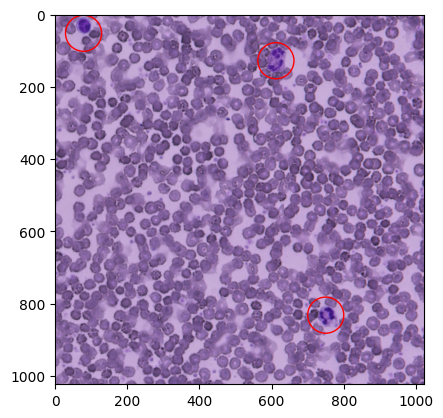

In [164]:
img = funcs.get_image_from_path(file_path=image_dir/"Good_Patches"/ key)

fig,ax = plt.subplots()

for i, roi_file in enumerate(roi_in_files):
    roi_img = funcs.get_image_from_path(file_path=roi_file)
    x,y,w,h = find_roi_in_image(image=img, roi=roi_img)
    ax.add_patch(plt.Circle(xy=(x,y), radius=50, color=(1,0,0), fill=False))
ax.imshow(img)
plt.show()    

In [167]:
roi_in_files[0].parts[-2]

'Lymphocyte'